In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.datasets import fetch_20newsgroups
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

!pip install pyod
from pyod.models.knn import KNN
from pyod.models.auto_encoder import AutoEncoder

!pip install umap-learn
import umap

!pip install tensorflow-hub
import tensorflow as tf
import tensorflow_hub as hub

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
embed = hub.load(module_url)

  Created wheel for pyod: filename=pyod-0.8.1-cp37-none-any.whl size=105658 sha256=68a93cf06d58ca5d1faa4ad76b973d34a62b6d8804bd1c9589a1da48b4487866
  Stored in directory: C:\Users\mrric\AppData\Local\pip\Cache\wheels\2e\ca\18\727e9d98a41f5f4385a97d5b429f3a9c8fbee13f9780c18642
  Created wheel for combo: filename=combo-0.1.1-cp37-none-any.whl size=42119 sha256=8bdacdaeccd9de84ee0ca6408318d575fc97747429441774b28b49e963c98ce2
  Stored in directory: C:\Users\mrric\AppData\Local\pip\Cache\wheels\55\ec\e5\a2331372c676c467e70c6646e646edf6997d5c4905b8c0f5e6
  Created wheel for suod: filename=suod-0.0.4-cp37-none-any.whl size=2167164 sha256=c33705bf68d93c85e5806972e3b4427842f4b02d545917a21547b683bfe6e732
  Stored in directory: C:\Users\mrric\AppData\Local\pip\Cache\wheels\57\55\e5\a4fca65bba231f6d0115059b589148774b41faea25b3f2aa27
Successfully built pyod combo suod


Using TensorFlow backend.
C:\Users\mrric\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\mrric\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\mrric\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\mrric\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

# Load data
Split into training, novel test, and non-novel test data

## Load extracted n26 data

In [42]:
vectors = pd.read_csv("data/extracted_n26_tsv_vecs.tsv", delimiter='\t|,', header=None, engine='python')
vectors = vectors.drop(vectors.columns[0], axis=1)
metadata = pd.read_csv("data/extracted_n26_tsv_metadata.tsv", delimiter='\t')

vec_meta = vectors.join(metadata)
train = vec_meta[vec_meta['FAQ_id'] <= 134] # only train on first 130 classes
train = train.drop(['FAQ_id', 'locale', 'market', 'question'], axis=1)

test_novel = vec_meta[vec_meta['FAQ_id'] > 134]
test_novel = test_novel.drop(['FAQ_id', 'locale', 'market', 'question'], axis=1)

test_not_novel = train.sample(n=30, random_state=56) # random sample of non-novel clusters
train = pd.concat([train,test_not_novel]).drop_duplicates(keep=False) # train data cannot contain test data

## Load and embed 20newsgroups data

In [3]:
print("Loading 20newsgroups data...")
newsgroups_train = fetch_20newsgroups(subset='train', categories=['sci.crypt', 'sci.electronics', 'sci.med', 'sci.space'])
newsgroups_test_novel = fetch_20newsgroups(subset='test', categories=['rec.autos', 'rec.motorcycles'])
newsgroups_test_not_novel = fetch_20newsgroups(subset='test', categories=['sci.crypt', 'sci.electronics', 'sci.med', 'sci.space'])

print("Loading tensorflow session...")
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    
    print("Embedding training text...")
    train = session.run(embed(newsgroups_train.data))
    train_vec_df = pd.DataFrame(train)
    train_vec_df.insert(loc=0, column='category', value=newsgroups_train.target)
    train_vec_df.to_csv (r'data/train_vec.csv', index=False)
    
    print("Embedding novel test text...")
    test_novel = session.run(embed(newsgroups_test_novel.data))
    test_novel_vec_df = pd.DataFrame(test_novel)
    labels = newsgroups_test_novel.target + len(newsgroups_train.target_names)
    test_novel_vec_df.insert(loc=0, column='category', value=labels)
    test_novel_vec_df.to_csv (r'data/test_novel_vec.csv', index=False)
    
    print("Embedding non-novel test text...")
    test_not_novel = session.run(embed(newsgroups_test_not_novel.data))
    test_not_novel_vec_df = pd.DataFrame(test_not_novel)
    test_not_novel_vec_df.insert(loc=0, column='category', value=newsgroups_test_not_novel.target)
    test_not_novel_vec_df.to_csv (r'data/test_not_novel_vec.csv', index=False)

print(train.shape)
print(test_novel.shape)
print(test_not_novel.shape)

Loading 20newsgroups data...
Loading tensorflow session...
Embedding training text...


KeyboardInterrupt: 

In [67]:
# Load pre-embedded data
train = pd.read_csv('data/train_vec.csv')
test_novel = pd.read_csv('data/test_novel_vec.csv')
test_not_novel = pd.read_csv('data/test_not_novel_vec.csv')

# Dimensionality reduction
Results in better outlier detection
UMAP works better than PCA

In [68]:
reducer = umap.UMAP(n_components=20)
# reducer = PCA(n_components=20)
def reduce(dataframe):
#     labels = pd.DataFrame(dataframe).join(metadata)['FAQ_id']
#     scaled_data = StandardScaler().fit_transform(dataframe)
#     embedding = reducer.fit_transform(scaled_data)
    labels = dataframe['category']
    scaled_data = StandardScaler().fit_transform(dataframe.loc[:, '1'::])
    embedding = reducer.fit_transform(scaled_data)
    return embedding

reduced_train = reduce(train)
reduced_test_novel = reduce(test_novel)
reduced_test_not_novel = reduce(test_not_novel)

# reduced_train = train
# reduced_test_novel = test_novel
# reduced_test_not_novel = test_not_novel

## Local outlier detection example

In [8]:
# Local outlier detection
lof = LocalOutlierFactor(n_neighbors=10, contamination=0.01)
train_df = pd.DataFrame(train)
train_df['lof'] = lof.fit_predict(train)

# Getting the negative LOF score
train_df['negative_outlier_factor'] = lof.negative_outlier_factor_
# print(train_data.head)

outliers = train_df[train_df['lof'] == -1].join(metadata)
print(outliers.head)
# print(outliers['FAQ_id', 'locale', 'market', 'question'])

NameError: name 'metadata' is not defined

# Novelty detection

## Clustering method

In [137]:
def tune_hyperparam(nn, contam):
    # Novelty detection
#     print("Fitting LOF...")
    lof = LocalOutlierFactor(n_neighbors=nn, contamination=contam, novelty=True)
    lof.fit(reduced_train)

    # Should predict -1 for all elements in test_novel
    # All examples in test_novel are new categories
#     print("Predicting novel test examples...")
    y_pred_test_novel = lof.predict(reduced_test_novel)
    num_test_novel = y_pred_test_novel[y_pred_test_novel == -1].size

    # Should predict 1 for all elements in test_not_novel
#     print("Predicting non-novel test examples...")
    y_pred_test_not_novel = lof.predict(reduced_test_not_novel)
    num_test_not_novel = y_pred_test_not_novel[y_pred_test_not_novel == 1].size
    return num_test_novel, y_pred_test_novel.size, num_test_not_novel, y_pred_test_not_novel.size


for n_components in range(57,58):
    # Dimensionality reduction
    # reducer = umap.UMAP(n_components=50)
    print("n_components: " + str(n_components))
    reducer = PCA(n_components=n_components)
    reduced_train = reduce(train)
    reduced_test_novel = reduce(test_novel)
    reduced_test_not_novel = reduce(test_not_novel)
    for n_neighbors in range(75,100,2):
        print("--n_neighbors: " + str(n_neighbors))
        for contamination in [x/100 for x in range(1, 11, 2)]:
            num_novel, novel_size, num_nonnovel, nonnovel_size = tune_hyperparam(n_neighbors, contamination)
            novel_acc = num_novel/novel_size
            nonnovel_acc = num_nonnovel/nonnovel_size
            if novel_acc + nonnovel_acc > 1.235:
                print("----Neighbors:" + str(n_neighbors))
                print("----Contamination: " + str(contamination))
                print("----Novel test acc: " + str(num_novel) + '/' + str(novel_size) + ' = ' + str(novel_acc))
                print("----Non-novel test acc: " + str(num_nonnovel) + '/' + str(nonnovel_size) + ' = ' + str(nonnovel_acc))
                print()

n_components: 57
--n_neighbors: 75
--n_neighbors: 77
--n_neighbors: 79
--n_neighbors: 81
--n_neighbors: 83
--n_neighbors: 85
--n_neighbors: 87
--n_neighbors: 89
--n_neighbors: 91


KeyboardInterrupt: 

## Autoencoder method

In [69]:
# Novelty detection using autoencoders
X_train = reduced_train

clf1 = AutoEncoder(hidden_neurons =[25, 15, 10, 2, 10,15, 25])
clf1.fit(X_train)

# Get the outlier scores for the train data
y_train_scores = clf1.decision_scores_  

# Predict the anomaly scores
y_test_novel_scores = clf1.decision_function(reduced_test_novel)  # outlier scores
y_test_novel_scores = pd.Series(y_test_novel_scores)
y_test_not_novel_scores = clf1.decision_function(reduced_test_not_novel)  # outlier scores
y_test_not_novel_scores = pd.Series(y_test_not_novel_scores)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_184 (Dense)            (None, 20)                420       
_________________________________________________________________
dropout_163 (Dropout)        (None, 20)                0         
_________________________________________________________________
dense_185 (Dense)            (None, 20)                420       
_________________________________________________________________
dropout_164 (Dropout)        (None, 20)                0         
_________________________________________________________________
dense_186 (Dense)            (None, 25)                525       
_________________________________________________________________
dropout_165 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_187 (Dense)            (None, 15)              

Epoch 51/100
2135/2135 [==============================] - 0s 184us/step - loss: 1.5548 - val_loss: 1.5860
Epoch 52/100
2135/2135 [==============================] - 0s 171us/step - loss: 1.5366 - val_loss: 1.5712
Epoch 53/100
2135/2135 [==============================] - 0s 169us/step - loss: 1.5193 - val_loss: 1.5569
Epoch 54/100
2135/2135 [==============================] - 0s 166us/step - loss: 1.5038 - val_loss: 1.5432
Epoch 55/100
2135/2135 [==============================] - 0s 167us/step - loss: 1.4883 - val_loss: 1.5298
Epoch 56/100
2135/2135 [==============================] - 0s 169us/step - loss: 1.4726 - val_loss: 1.5170
Epoch 57/100
2135/2135 [==============================] - 0s 142us/step - loss: 1.4628 - val_loss: 1.5043
Epoch 58/100
2135/2135 [==============================] - 0s 161us/step - loss: 1.4497 - val_loss: 1.4921
Epoch 59/100
2135/2135 [==============================] - 0s 189us/step - loss: 1.4362 - val_loss: 1.4802
Epoch 60/100
2135/2135 [======================

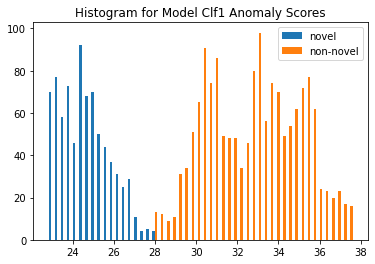

In [70]:
# Plot it!
plt.hist([y_test_novel_scores, y_test_not_novel_scores], bins=50, label=['novel', 'non-novel'])
plt.legend(prop={'size': 10})
plt.title("Histogram for Model Clf1 Anomaly Scores")
plt.show()